In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Import Data & Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df = df.drop(columns = ['duration']) # drop future information
df['ncalls'] = df['campaign'] - 1
df = df.drop(columns = ['campaign'])
df.shape

(41188, 20)

In [4]:
# check missing values
perc_missing_per_ftr = df.isnull().sum(axis = 0) / df.shape[0]
print('Fraction of Missing Values in Features:') 
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data Types of the Features with Missing Values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(df.isnull().sum(axis = 1) != 0) / df.shape[0]
print('Fraction of Rows with Missing Values:', frac_missing)

Fraction of Missing Values in Features:
job          0.008012
marital      0.001942
education    0.042027
default      0.208726
housing      0.024036
loan         0.024036
pdays        0.963217
dtype: float64
Data Types of the Features with Missing Values:
job           object
marital       object
education     object
default       object
housing       object
loan          object
pdays        float64
dtype: object
Fraction of Rows with Missing Values: 0.9681946197921725


In [5]:
# deal with pdays
def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df['pdays'] = df['pdays'].apply(categorize_pdays)

In [6]:
np.unique(df['pdays'], return_counts = True)

(array(['contacted between 15 to 21 days',
        'contacted between 22 to 28 days',
        'contacted between 8 to 14 days', 'contacted immediately',
        'contacted within a week', 'never contacted'], dtype=object),
 array([   56,     6,   276,    15,  1162, 39673]))

## EDA

In [7]:
print(df.shape)
print(df.dtypes)

(41188, 20)
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
pdays              object
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
ncalls              int64
dtype: object


In [8]:
# check if imbalanced
print(np.unique(df.y, return_counts = True)) # yes takes up 11%
sum(df.y == 'yes') / df.shape[0]

(array(['no', 'yes'], dtype=object), array([36548,  4640]))


0.11265417111780131

In [9]:
# check missing values
perc_missing_per_ftr = df.isnull().sum(axis = 0) / df.shape[0]
print('Fraction of Missing Values in Features:') 
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data Types of the Features with Missing Values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(df.isnull().sum(axis = 1) != 0) / df.shape[0]
print('Fraction of Rows with Missing Values:', frac_missing)

Fraction of Missing Values in Features:
job          0.008012
marital      0.001942
education    0.042027
default      0.208726
housing      0.024036
loan         0.024036
dtype: float64
Data Types of the Features with Missing Values:
job          object
marital      object
education    object
default      object
housing      object
loan         object
dtype: object
Fraction of Rows with Missing Values: 0.25978440322424007


## Visualization

[0.11265417111780131, 0.8873458288821987]

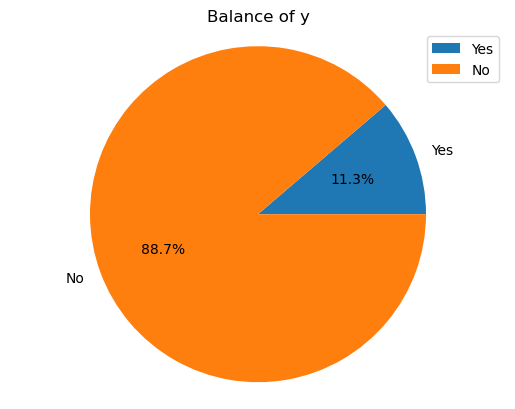

In [10]:
# pie chart of y
labels = 'Yes', 'No'
sizes = [sum(df.y == 'yes') / df.shape[0], sum(df.y == 'no') / df.shape[0]]
fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, autopct = '%1.1f%%')
ax.axis('equal') 
ax.legend(labels, loc = 'upper right')
ax.set_title('Balance of y')
plt.savefig('/Users/ihiro/Desktop/balance_of_y.png', dpi = 300)
sizes

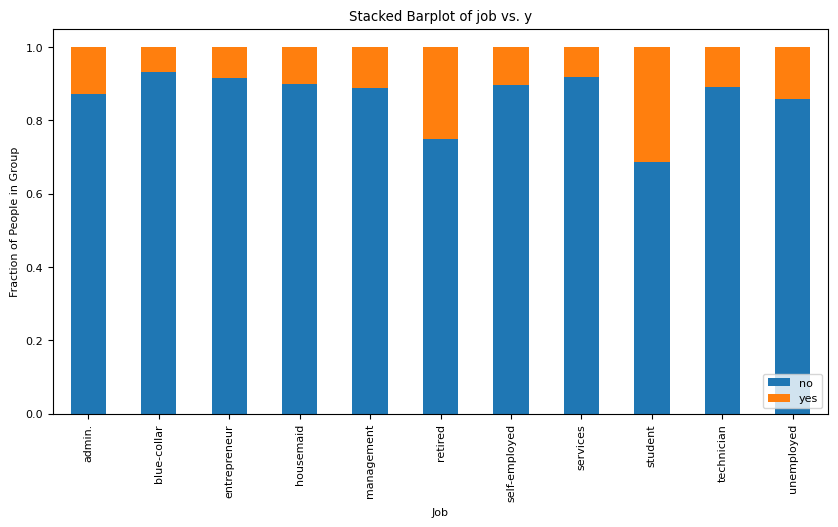

In [192]:
# job vs. y
count_matrix = df.groupby(['job', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
count_matrix_norm.plot(kind = 'bar', stacked = True, figsize = (10, 5)) 
plt.ylabel('Fraction of People in Group')
plt.xlabel('Job')
plt.legend(loc = 4)
plt.title('Stacked Barplot of job vs. y')
plt.savefig('/Users/ihiro/Desktop/stacked_barplot_job.png', dpi = 300, bbox_inches = 'tight')
plt.show()

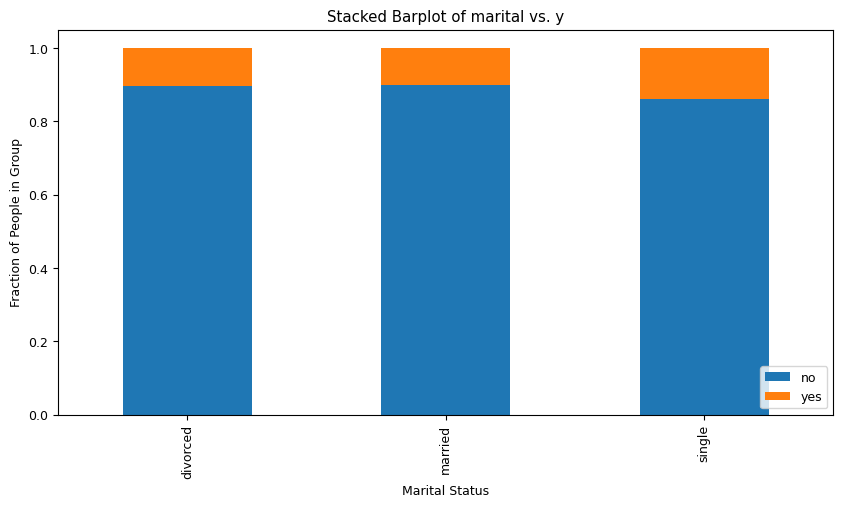

In [69]:
# marital vs. y
count_matrix = df.groupby(['marital', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
count_matrix_norm.plot(kind = 'bar', stacked = True, figsize = (10, 5)) 
plt.ylabel('Fraction of People in Group')
plt.xlabel('Marital Status')
plt.legend(loc = 4)
plt.title('Stacked Barplot of marital vs. y')
plt.savefig('/Users/ihiro/Desktop/stacked_barplot_marital.png', dpi = 300, bbox_inches = 'tight')
plt.show()

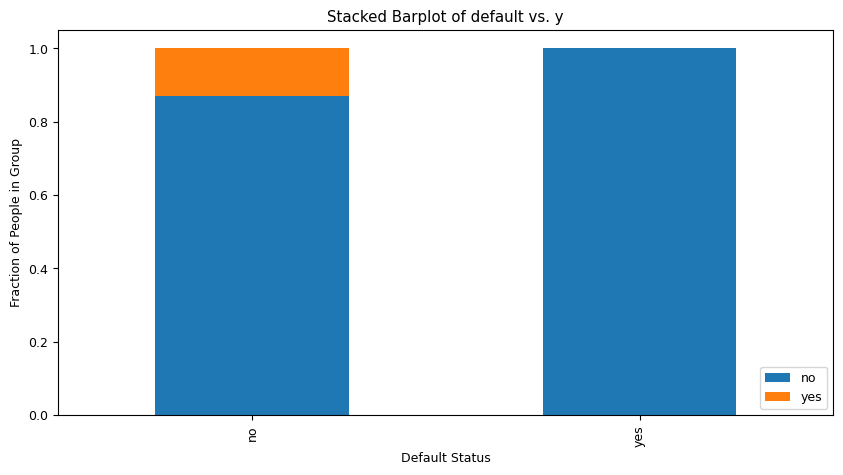

In [70]:
# default vs. y
count_matrix = df.groupby(['default', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
count_matrix_norm.plot(kind = 'bar', stacked = True, figsize = (10, 5)) 
plt.ylabel('Fraction of People in Group')
plt.xlabel('Default Status')
plt.legend(loc = 4)
plt.title('Stacked Barplot of default vs. y')
plt.savefig('/Users/ihiro/Desktop/stacked_barplot_default.png', dpi = 300, bbox_inches = 'tight')
plt.show()

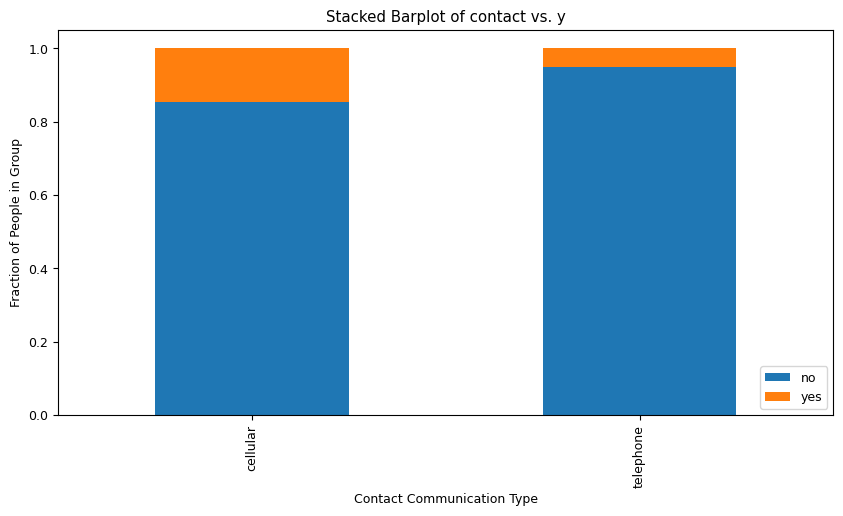

In [71]:
# contact vs. y
count_matrix = df.groupby(['contact', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
count_matrix_norm.plot(kind = 'bar', stacked = True, figsize = (10, 5)) 
plt.ylabel('Fraction of People in Group')
plt.xlabel('Contact Communication Type')
plt.legend(loc = 4)
plt.title('Stacked Barplot of contact vs. y')
plt.savefig('/Users/ihiro/Desktop/stacked_barplot_contact.png', dpi = 300, bbox_inches = 'tight')
plt.show()

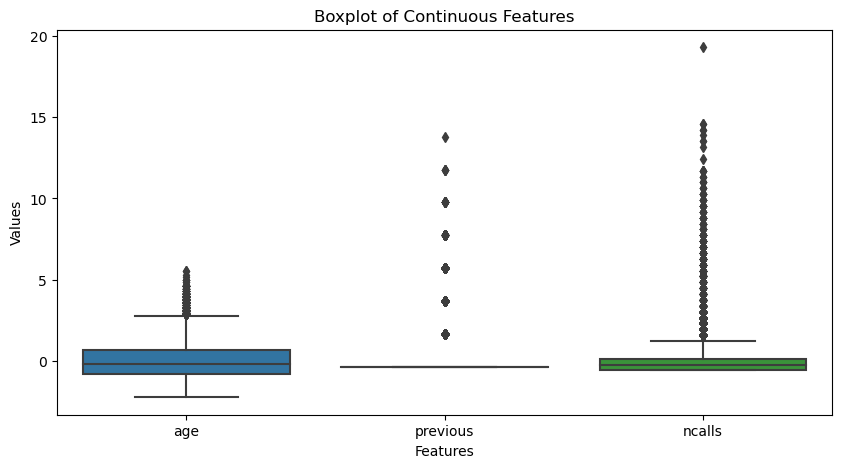

In [15]:
# boxplot of all numeric features
scaler = StandardScaler()
df_num = df[['age', 'previous', 'ncalls']]
num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)
plt.figure(figsize = (10, 5))
sns.boxplot(data = num_scaled).set(title = 'Boxplot of Continuous Features', xlabel = 'Features', ylabel = 'Values')
plt.savefig('/Users/ihiro/Desktop/boxplot_numeric_features.png', dpi = 300, bbox_inches = 'tight')
plt.show()

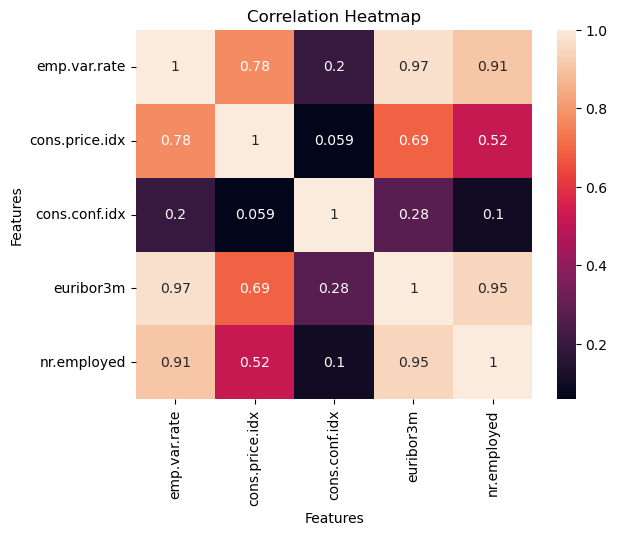

In [16]:
# correlation heatmap
df_econ = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
econ_corr = df_econ.corr()
sns.heatmap(econ_corr, annot = True).set(title = 'Correlation Heatmap', xlabel = 'Features', ylabel = 'Features')
plt.savefig('/Users/ihiro/Desktop/heatmap.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [17]:
df = df.drop(columns = ['emp.var.rate', 'euribor3m'])

In [18]:
X = df.drop(columns = 'y')
y = df['y']
y = y.replace({'yes': 1, 'no': 0})
print(X.shape)
print(y.shape)

(41188, 17)
(41188,)


## Define Preprocessor

In [19]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]

num_ftrs = ['age', 'previous', 'ncalls', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

In [20]:
# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

## ML Pipeline

In [22]:
def MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3):
    test_scores = []
    best_models = []
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    for i, random_state in enumerate(random_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, random_state = 42 * random_state, test_size = 0.2, 
                                                            stratify = y)
        # imbalanced data set
        kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42 * random_state)
        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state = 42 * random_state)
        else:
            ML_algo = ML_algo

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid,
                            scoring = fbeta_scorer, cv = kf,
                            return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        #print('Best model parameter(s):', grid.best_params_)
        #print('Validation score:', grid.best_score_)
        best_models.append(grid) # save the model
        #y_test_pred_prob = best_models[-1].predict_proba(X_test)[:, 1]
        y_test_pred = best_models[-1].predict(X_test)

        # confusion matrix
        #cm = confusion_matrix(y_test, y_test_pred)
        #disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
        #fig, ax = plt.subplots(figsize = (5, 3))
        #disp.plot(ax = ax)
        #plt.tight_layout()
        #plt.show()
        
        test_fbeta = fbeta_score(y_test, y_test_pred, beta = 1)
        test_scores.append(test_fbeta)
        #print('Test average precision:', test_scores[i])
    return test_scores, best_models

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

random_states = [42, 0, 456]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_rf, best_models_rf = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_rf))
print('Standard deviation:', np.std(test_scores_rf))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean: 0.5046434070387497
Standard deviation: 0.004389040252001994


### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

random_states = [0, 42, 456]
ML_algo = LogisticRegression(solver = 'saga', penalty = None, max_iter = 1000000)
param_grid = {
    'logisticregression__class_weight': [None, 'balanced', 
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_log, best_models_log = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_log))
print('Standard deviation:', np.std(test_scores_log))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mean: 0.45468073602456166
Standard deviation: 0.003276140653340845


### Elastic Net

In [51]:
random_states = [0, 42, 456]
ML_algo = LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__l1_ratio': [0.3, 0.5, 0.8],
    'logisticregression__class_weight': [None, 'balanced',
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_en, best_models_en = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_en))
print('Standard deviation:', np.std(test_scores_en))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mean: 0.46478726156824973
Standard deviation: 0.014053850296836782


## Lasso

In [58]:
random_states = [0, 42, 456]
ML_algo = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__class_weight': [None, 'balanced',
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_l1, best_models_l1 = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_l1))
print('Standard deviation:', np.std(test_scores_l1))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mean: 0.46845381768555355
Standard deviation: 0.011270739894206122


## Ridge

In [59]:
random_states = [0, 42, 456]
ML_algo = LogisticRegression(penalty = 'l2', solver = 'saga', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__class_weight': [None, 'balanced',
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_l2, best_models_l2 = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_l2))
print('Standard deviation:', np.std(test_scores_l2))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mean: 0.456179164114453
Standard deviation: 0.0030112092864905335


### XGBoost

In [30]:
def MLpipe_XGBoost(X, y, preprocessor, random_states):
    test_scores = []
    train_scores = []
    best_models = []
    test_sets = [] # save each random state's test set into a list
    #fbeta_scorer = make_scorer(fbeta_score, beta = 1)

    for random_state in random_states:
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size = 0.6,
                                                              random_state = 42 * random_state, stratify = y)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size = 0.5,
                                                        random_state = 42 * random_state, stratify = y_other)
        # preprocessing
        df_train = pd.DataFrame(data = preprocessor.fit_transform(X_train), 
                                columns = preprocessor.get_feature_names_out())
        df_val = pd.DataFrame(data = preprocessor.transform(X_val), 
                              columns = preprocessor.get_feature_names_out())
        df_test = pd.DataFrame(data = preprocessor.transform(X_test), 
                               columns = preprocessor.get_feature_names_out())

        # save each random state's test set into a list
        # save both the feature matrix and the target series
        df_y = pd.DataFrame(data = y_test, columns = ['y']).reset_index(drop = True)
        df_test1 = df_test.reset_index(drop = True)
        df_combined = pd.concat([df_test1, df_y], axis = 1)
        test_sets.append(df_combined)
        
        param_grid = {
            'max_depth': [1, 3, 10, 30, 100],
            'learning_rate': [0.33],
            'n_estimators': [10000],
            'seed': [0],
            'reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            'subsample': [0.66],
            'colsample_bytree': [0.9],
            'scale_pos_weight': [1, 7.87]
        }
       
        best_fbeta_score = 0
        best_model = None
        best_params = None

        for params in ParameterGrid(param_grid):
            clf = XGBClassifier(random_state = 42 * random_state)
            clf.set_params(**params, early_stopping_rounds = 50)
            clf.fit(df_train, y_train, eval_set = [(df_val, y_val)], 
                    verbose = False)
            y_val_pred = clf.predict(df_val)
            fbeta_score_val = fbeta_score(y_val, y_val_pred, beta = 1)
            if fbeta_score_val > best_fbeta_score:
                best_fbeta_score = fbeta_score_val
                best_model = clf
                best_params = params
       
        best_models.append(best_model)
        train_score = fbeta_score(y_train, best_model.predict(df_train), beta = 1)
        test_score = fbeta_score(y_test, best_model.predict(df_test), beta = 1)
        test_scores.append(test_score)
        train_scores.append(train_score)
                            
    #print(f'Mean: {np.mean(test_scores)}')
    #print(f'Standard deviation: {np.std(test_scores)}')
    return best_models, test_scores, test_sets

In [52]:
import xgboost
from xgboost import XGBClassifier

random_states = [0, 42, 456]
best_models_xgb, test_scores_xgb, test_sets_xgb = MLpipe_XGBoost(X, y, preprocessor, random_states)

print('Mean:', np.mean(test_scores_xgb))
print('Standard deviation:', np.std(test_scores_xgb))

Mean: 0.44926887372506313
Standard deviation: 0.01360677171212778


## Test Results

In [63]:
# baseline
tp = 4640
fp = 36548
fn = 0
r = tp / (tp + fn)
p = tp / (tp + fp)
base = (2 * p * r) / (p + r); base

0.2024962904774374

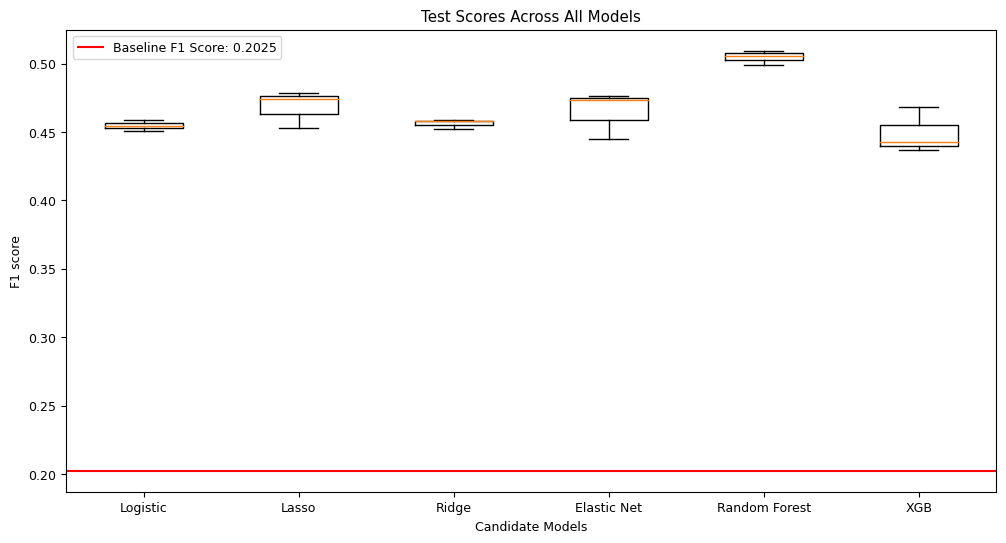

In [76]:
all_test_scores = [test_scores_log, test_scores_l1, test_scores_l2, test_scores_en, test_scores_rf,
                   test_scores_xgb]
plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 9})
plt.boxplot(all_test_scores)
plt.xticks([1, 2, 3, 4, 5, 6], ['Logistic', 'Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 'XGB'])
plt.title('Test Scores Across All Models')
plt.ylabel('F1 score')
plt.xlabel('Candidate Models')
plt.axhline(y = base, color = 'r', linestyle = '-', label = f'Baseline F1 Score: {base:.4f}')
plt.legend()
plt.savefig('/Users/ihiro/Desktop/boxplot_scores.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Confusion Matrix (Omitted)

In [ ]:
def MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 5):
    test_scores = []
    best_models = []
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    for i, random_state in enumerate(random_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, random_state = 42 * random_state, test_size = 0.2)
        # imbalanced data set
        kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42 * random_state)
        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state = 42 * random_state)
        else:
            ML_algo = ML_algo

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid,
                            scoring = fbeta_scorer, cv = kf,
                            return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        #print('Best model parameter(s):', grid.best_params_)
        #print('Validation score:', grid.best_score_)
        best_models.append(grid) # save the model
        #y_test_pred_prob = best_models[-1].predict_proba(X_test)[:, 1]
        y_test_pred = best_models[-1].predict(X_test)

        # confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
        fig, ax = plt.subplots(figsize = (5, 3))
        disp.plot(ax = ax)
        plt.tight_layout()
        plt.title('Confusion matrix in random forest')
        plt.savefig('/Users/ihiro/Desktop/confusion_matrix.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        test_fbeta = fbeta_score(y_test, y_test_pred, beta = 1)
        test_scores.append(test_fbeta)
        #print('Test average precision:', test_scores[i])
    return test_scores, best_models

In [ ]:
random_states = [42]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

a, b = MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

## Interpretability (Omitted)

In [ ]:
df1 = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df1 = df1.drop(columns = ['duration']) # drop future information
df1['ncalls'] = df1['campaign'] - 1
df1 = df1.drop(columns = ['campaign'])

In [ ]:
def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df1['pdays'] = df1['pdays'].apply(categorize_pdays)
print(df1.shape)

In [ ]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
num_ftrs = ['age', 'previous', 'ncalls', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
            'euribor3m', 'nr.employed']

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [ ]:
random_states = [42]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

c, d = MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

## Global

### RandomForestClassification.feature_importances_

In [79]:
def MLpipe_global(X, y, n_folds):
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 * 42, stratify = y)
    kf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42 * 42)
    cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']
    num_ftrs = ['age', 'previous', 'ncalls', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'] # numeric
    ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
    ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                     'professional.course', 'university.degree'],
                    ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                    ['mon', 'tue', 'wed', 'thu', 'fri'], 
                    ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                     'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
        ('scaler', StandardScaler())])
    # ordinal encoder
    ordinal_transformer = Pipeline(steps = [
        ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
        ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
        ('scaler', StandardScaler())])
    # standard scaler
    numeric_transformer = Pipeline(steps = [
        ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, num_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ord', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state = 42 * 42))
    param_grid = {
        'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
        'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1.0],
        'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', {0: 1, 1: 5}, {0: 1, 1: 10}]
    }

    # prepare Gridsearch
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = fbeta_scorer,
                        cv = kf, return_train_score = True, n_jobs = -1,
                        verbose = True)
    grid.fit(X_other, y_other)
    y_test_pred = grid.predict(X_test)
    base_f1 = fbeta_score(y_test, y_test_pred, beta = 1)
    return grid, X_test, y_test, base_f1

In [80]:
model_42, X_test_42, y_test_42, base_42 = MLpipe_global(X, y, 3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [162]:
print(np.unique(y_test_42, return_counts = True)) # yes takes up 11%
sum(y_test_42 == 1) / y_test_42.shape[0]

(array([0, 1]), array([7310,  928]))


0.11264870114105366

In [82]:
best_pipe_42 = model_42.best_estimator_
best_model_42 = best_pipe_42.named_steps['randomforestclassifier']
importance_value_42 = best_model_42.feature_importances_
ftr_names = best_pipe_42.named_steps['columntransformer'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': ftr_names, 'Importance': importance_value_42}).sort_values(by = 'Importance', 
                                                                                                    ascending = False).head(10)
importance_df

,Feature,Importance
5,num__nr.employed,0.279234
4,num__cons.conf.idx,0.122821
3,num__cons.price.idx,0.087887
35,cat__poutcome_success,0.074812
39,ord__pdays,0.071823
37,ord__month,0.057788
0,num__age,0.045027
32,cat__contact_telephone,0.029341
1,num__previous,0.027067
34,cat__poutcome_nonexistent,0.025803


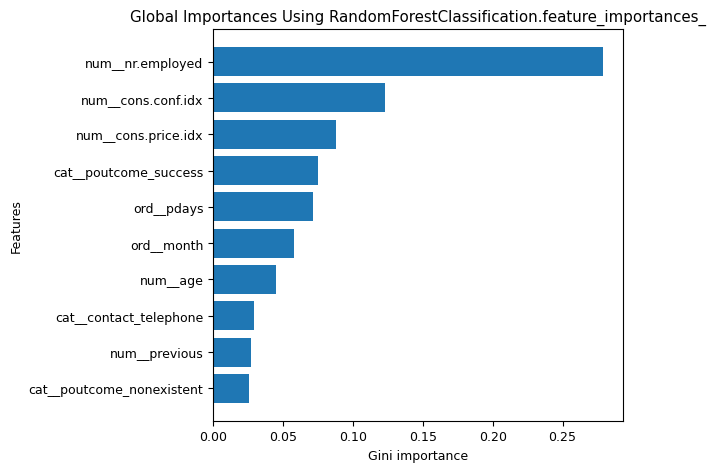

In [83]:
importance_df.sort_values(by = 'Importance', ascending = True, inplace = True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Gini importance')
plt.ylabel('Features')
plt.title('Global Importances Using RandomForestClassification.feature_importances_')
plt.tight_layout()
plt.savefig('/Users/ihiro/Desktop/global_RandomForestClassfication.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Permutation

In [95]:
from sklearn.metrics import f1_score

nr_runs = 10
ftr_names = X.columns
scores = np.zeros([len(ftr_names), nr_runs])

for i in range(len(ftr_names)):
    #print('Shuffling ' + str(ftr_names[i]))
    f1_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        shuffled_f1_score = f1_score(y_test, model_42.predict(X_test_shuffled))
        f1_scores.append(shuffled_f1_score)
    mean_f1_score = np.mean(f1_scores)
    std_f1_score = np.std(f1_scores)
    #print('   Shuffled F1 Score:', np.around(mean_f1_score, 3), '+/-', np.around(std_f1_score, 3))
    scores[i] = f1_scores

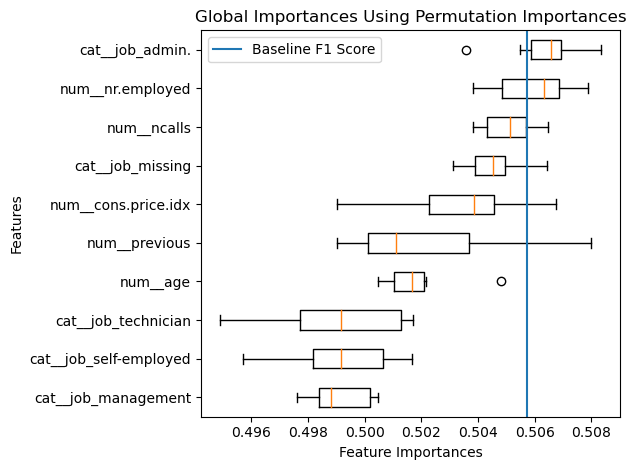

In [134]:
sorted_idx = np.argsort(np.mean(scores, axis = 1))[::-1][:10]
plt.rcParams.update({'font.size': 10})
plt.boxplot(scores[sorted_idx][::-1].T, labels = ftr_names[sorted_idx][::-1], vert = False)
plt.axvline(base_42, label = 'Baseline F1 Score')
plt.legend()
plt.ylabel('Features')
plt.xlabel('Feature Importances')
plt.title('Global Importances Using Permutation Importances')
plt.tight_layout()
plt.savefig('/Users/ihiro/Desktop/global_permutation.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### SHAP

In [110]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_42.best_estimator_[1])
X_test_transformed = model_42.best_estimator_[0].transform(X_test_42)
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(2, 1000, 40)


In [169]:
print(explainer.expected_value)

array([0.61104975, 0.38895025])

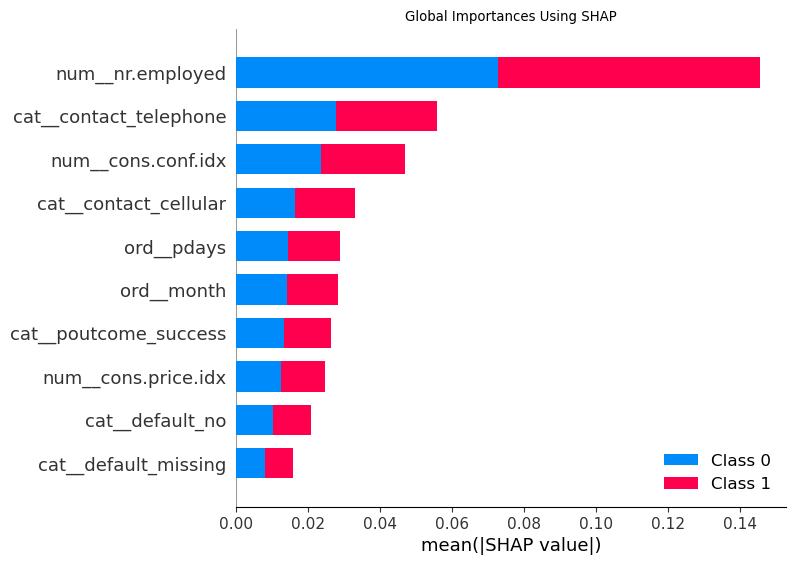

In [147]:
ftr_names = best_pipe_42.named_steps['columntransformer'].get_feature_names_out()
shap_summary = np.mean(np.abs(shap_values), axis = 0)
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = ftr_names, 
                  max_display = 10, show = False)
plt.title('Global Importances Using SHAP')
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('mean(|SHAP value|)')
plt.savefig('/Users/ihiro/Desktop/global_SHAP.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Local

In [148]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_42.best_estimator_[1])
X_test_transformed = model_42.best_estimator_[0].transform(X_test_42)
print(np.shape(X_test_transformed))

shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(8238, 40)
(2, 1000, 40)


0.6110497519002311


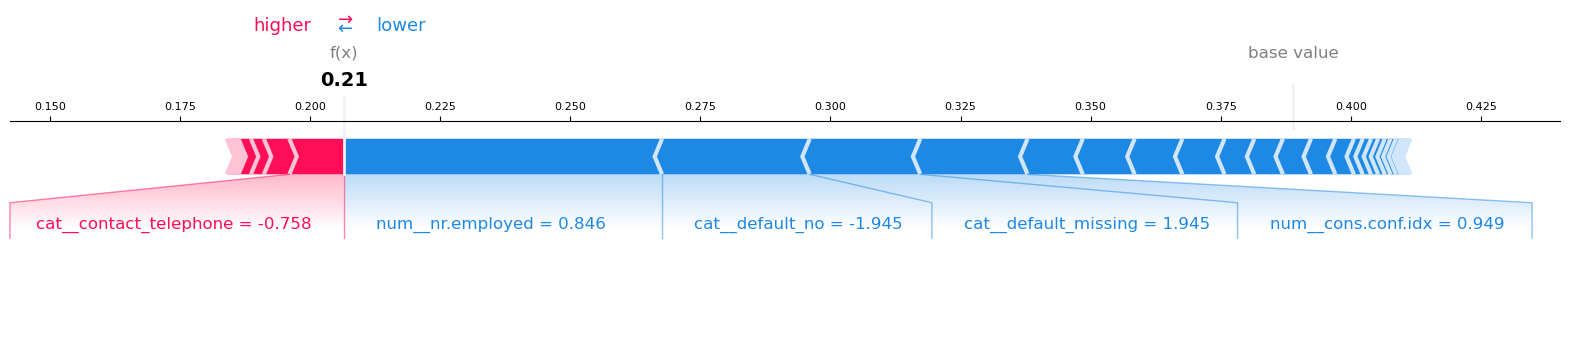

In [177]:
index = 691 # true label is 0
print(explainer.expected_value[0]) # class 1 pred proba
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][index,:], features = np.round(X_test_transformed[index,:], 3), feature_names = ftr_names, 
                show = False, matplotlib = True) # will predict class 0
#plt.savefig('/Users/ihiro/Desktop/force_plot_691.png', dpi = 300, bbox_inches = 'tight')

0.38895024809976864


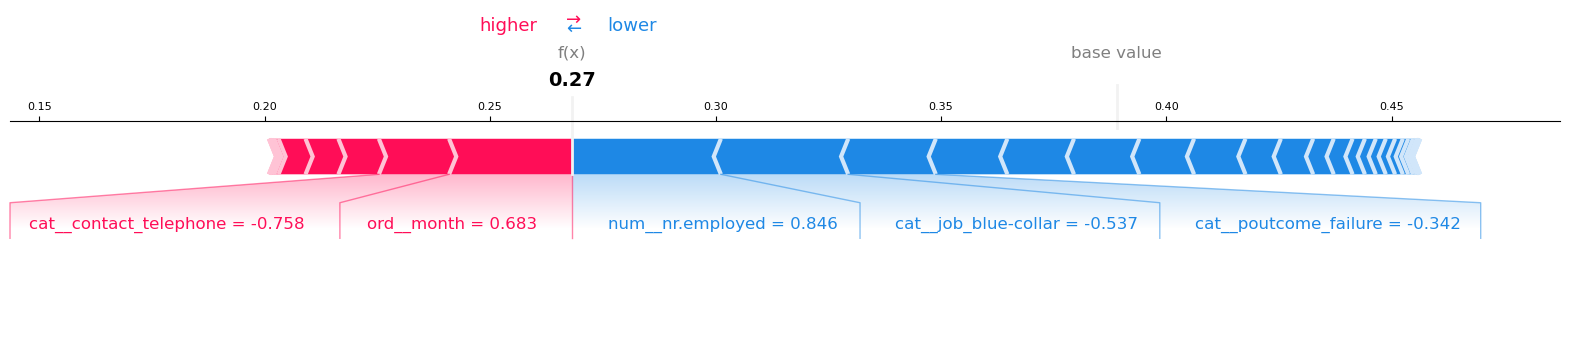

In [185]:
index = 872 # true label is 1
print(explainer.expected_value[1]) # class 1 pred proba
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][index,:], features = ftr_importances, 
                feature_names = ftr_names, show = False, matplotlib = True)
#plt.savefig('/Users/ihiro/Desktop/force_plot_872.png', dpi = 300, bbox_inches = 'tight')

In [194]:
X_test.iloc[691]

age                            37
job                    technician
marital                   married
education             high.school
default                       NaN
housing                       yes
loan                           no
contact                  cellular
month                         aug
day_of_week                   tue
pdays             never contacted
previous                        0
poutcome              nonexistent
cons.price.idx             93.444
cons.conf.idx               -36.1
nr.employed                5228.1
ncalls                          1
Name: 20430, dtype: object